# Intro to Data Science @ SzISz Part III.
## Data Transformation

### Table of contents
- <a href="#What-is-Data-Transformation?">Theory</a>
- <a href="#Numerical-Features">Numerical Transformations</a>
- <a href="#Textual-Transformations">Textual Transformations</a>
- <a href="#Pipelines-and-FeatureUnions">Pipelines and Feature Unions</a>

## What is Data Transformation?
During data transformation the goal is to prepare the data to be usable in the modelling steps. These transformations include normalization, standardization, text processing, generating complex features from basic ones, or any kind of data mapping.

_"...a data transformation converts a set of data values from the data format of a source data system into the data format of a destination data system._

_Data transformation can be divided into two steps:_
1. _data mapping maps data elements from the source data system to the destination data system and captures any transformation that must occur_
2. _code generation that creates the actual transformation program"_
from: <a href="https://en.wikipedia.org/wiki/Data_transformation">Wikipedia</a>

## Why is it important?

Most of the models are sensitive to data, so you must transform it into a more desired format. Unfortunately the data you start with is usually in terrible shape:

- It has missing values
- It is full of outliers
- The data is distorted by noise
- The features are in different scales
- The features are correlated/redundant/uninformative


## Tools

- scaling/binarizing
- normalizing/standardizing
- outlier detecting
- filtering
- mathematical transformations
- representational changes
- etc.

---

## Imports and custom functions

In [1]:
%matplotlib inline
import collections

import numpy as np
import scipy.sparse as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification

In [2]:
def input_missing(X, random_state=42):
    """Randomly replace values in an np.ndarray with np.nan, np.inf or -np.inf.
    
    Parameters:
    -----------
    X : np.ndarray
        Target array in which the values will be randomly replaced.
        
    random_state : int
        Random seed initializing the pseudo-random number generator.
        
    Returns:
    --------
    X' : np.ndarray
        Array with nans and infs.
    """
    custom_random = np.random.RandomState(random_state)
    mask = custom_random.rand(*X.shape)
    mask[mask < 0.9] = 1.
    mask[(mask >= 0.9) & (mask < 0.95)] = np.nan
    mask[(mask >= 0.95) & (mask < 0.975)] = np.inf
    mask[(mask >= 0.975) & (mask < 1.)] = -np.inf
    return X * mask

def change_scale(X, factor=5., columns=1, random_state=42):
    """Randomly multiply a column or columns in an np.ndarray.
    
    Parameters:
    -----------
    X : np.ndarray
        Target array in which a column will be multiplied.
    
    factor : float
        The multiplication factor
        
    columns : int or array-like
        Number of columns to multiply if int type, else the column indices which are multiplied.
        
    random_state : int
        Random seed initializing the pseudo-random number generator.
        
    Returns:
    --------
    X' : np.ndarray
        Array with multiplied valued columns.
    """
    custom_random = np.random.RandomState(random_state)
    X_comma = X.copy()
    rows, cols = X.shape
    if not isinstance(columns, collections.Iterable):
        columns = [custom_random.randint(cols) for _ in xrange(columns)]
    for column in columns:
        X_comma[:, column] *= factor
    return X_comma

def add_outlier(X, value=10, num=1, random_state=42):
    """Add a specified number of outliers to the input np.ndarray.
    
    Parameters:
    -----------
    X : np.ndarray
        Target array in which the outliers will be inputted.
    
    value : float
        The value of the outlier.
        
    num : int
        The number of outliers to be placed.
        
    random_state : int
        Random seed initializing the pseudo-random number generator.
        
    Returns:
    --------
    X' : np.ndarray
        Array with outliers.
    """
    custom_random = np.random.RandomState(random_state)
    X_comma = X.copy()
    rows, cols = X_comma.shape
    for _ in xrange(num):
        row = custom_random.randint(rows)
        col = custom_random.randint(cols)
        X_comma[row, col] += value
    
    return X_comma

def binarize(X, bins=2):
    """Binarize matrix elements based on the values.
    
    Parameters:
    -----------
    X : np.ndarray
        Target array to binarize.
        
    bins : int
        Number of values to appear in the binarized matrix.
        
    Returns:
    --------
    X_comma : np.ndarray
        Binarized matrix
    """
    X_comma = X.copy()
    delims = np.linspace(X_comma.min(), X_comma.max(), bins+1)
    delims = zip(delims, delims[1:])
    for bin_val, (start, end) in enumerate(delims):
        X_comma[(start <= X) & (X <= end)] = bin_val
    return X_comma

In [3]:
def plot_row(axis, df, column, labels):
    """Scatterplot a column against all of the columns in a pd.DataFrame.
    Colors the points based on labels.
    
    Parameters:
    -----------
    axis : iterable of matplotlib.axes
        List of target axis.
        
    df : pd.DataFrame
        DataFrame to plot.
        
    column : str
        The DataFrame's column to plot against.
        
    labels : iterable
        The labels for the rows in the DataFrame.
    """
    for i, col_ax in zip(df.columns.values, axis):
        col_ax.scatter(df[column], df[i], c=labels, cmap='magma')

def gridplot(df, labels, columns=None, figsize=(12,12)):
    """Generate a gridplot over a pd.DataFrame's columns.
    If the columns parameter is specified, plot against that column(s).
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame to plot.
        
    labels : iterable
        The labels for the rows in the DataFrame.
        
    columns : None, pd.DataFrame columnname, iterable over pd.DF colnames
        The columns to plot against. If None, plot every column against every column.
        
    figsize : tuple of ints
        The size of the resulting plot.
    """
    if columns is None:
        columns = df.columns.values
    if not isinstance(columns, collections.Iterable):
        columns = [columns]
        
    ncols = len(df.columns)
    nrows = len(columns)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex="col", sharey="row", figsize=figsize)
    ax = ax.reshape(nrows, ncols)

    for col, row_ax in zip(columns, ax):
        plot_row(axis=row_ax, df=df, column=col, labels=labels)

    fig.show()

## Data generation

In [4]:
data, labels = make_classification(n_features=10, random_state=42)
df = pd.DataFrame(data)

---

## Numerical features


### <a href="http://pandas.pydata.org/pandas-docs/stable/missing_data.html">missing values</a>

In [5]:
missing = pd.DataFrame(input_missing(data))
missing.describe()

,0,1,2,3,4,5,6,7,8,9
count,97.000000,97.000000,94.000000,94.000000,96.000000,89.000000,94.000000,94.000000,94.000000,97.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
25%,-1.096621,-1.146581,-1.268565,-0.841926,-0.600541,-0.763259,-0.638544,-0.917703,-0.973481,-0.646573
50%,-0.218004,0.061945,-0.062267,0.142668,0.015618,0.096996,0.057802,-0.231242,-0.052817,0.224092
75%,1.203166,1.079542,1.135642,0.714228,0.617664,0.869606,0.756979,0.668178,0.627847,0.632782
max,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [8]:
dropped = missing.dropna(axis=0)
dropped.shape

(56, 10)

In [9]:
filled = missing.fillna(value=0)
filled.describe()

,0,1,2,3,4,5,6,7,8,9
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
25%,-1.080593,-1.142056,-1.209984,-0.819243,-0.571698,-0.563335,-0.582521,-0.899020,-0.854015,-0.631869
50%,-0.098046,0.008615,0.000000,0.023342,0.000000,0.000000,0.013046,-0.122440,-0.014437,0.188380
75%,1.178740,1.066188,1.083644,0.691366,0.611923,0.714129,0.733173,0.586429,0.598368,0.624553
max,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [11]:
interpolated = missing.interpolate(method='nearest')
interpolated.describe()

,0,1,2,3,4,5,6,7,8,9
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,100.000000,100.000000,100.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
25%,-1.080593,-1.205929,-1.234335,-0.843212,-0.600541,-0.738590,-0.625488,-0.908779,-0.989158,-0.631869
50%,-0.167681,0.039587,-0.110737,0.142668,-0.006946,0.098504,0.035264,-0.208246,-0.070257,0.229854
75%,1.229519,1.066188,1.083644,0.707311,0.617664,0.905707,0.740579,0.688590,0.618727,0.703942
max,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


### <a href="http://pandas.pydata.org/pandas-docs/stable/missing_data.html#values-considered-missing">infinite values</a>

In [22]:
pd.set_option('mode.use_inf_as_null', True)

In [15]:
np.finfo('d')

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [17]:
dropped = missing.dropna(axis=0)
dropped.shape

(36, 10)

In [20]:
filled = missing.fillna(value=0)
filled.describe()

,0,1,2,3,4,5,6,7,8,9
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.011547,-0.034583,-0.032387,-0.028267,0.018913,0.062069,0.087906,-0.114299,-0.115955,0.121959
std,1.247249,1.128557,1.265912,0.877394,0.870822,0.955141,0.950539,0.908122,1.013231,0.920885
min,-2.683180,-2.523434,-2.585909,-1.692005,-2.301921,-2.038125,-2.073390,-1.710168,-3.241267,-2.081929
25%,-0.967593,-0.986522,-1.138573,-0.802228,-0.498762,-0.498963,-0.496105,-0.857384,-0.634061,-0.586988
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.052893,0.000000,0.052843
75%,0.947307,0.768738,1.050418,0.669443,0.607100,0.592066,0.692567,0.528479,0.499182,0.518081
max,2.489048,2.388694,2.591239,1.724002,2.075401,2.445752,2.632382,2.270693,3.078881,2.573360


In [21]:
interpolated = missing.interpolate()
interpolated.describe()

,0,1,2,3,4,5,6,7,8,9
count,100.000000,98.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.020139,-0.051431,-0.069629,-0.008801,-0.002292,0.060378,0.053349,-0.095331,-0.173261,0.180914
std,1.292196,1.167470,1.299721,0.889684,0.901614,0.977368,0.981893,0.933474,1.044617,0.950000
min,-2.683180,-2.523434,-2.585909,-1.692005,-2.301921,-2.038125,-2.073390,-1.710168,-3.241267,-2.081929
25%,-1.031526,-1.041740,-1.185113,-0.802228,-0.571698,-0.673269,-0.582521,-0.857384,-0.908994,-0.586988
50%,-0.167681,-0.015700,-0.099134,0.183517,-0.006946,0.098504,-0.014102,-0.166594,-0.052817,0.240291
75%,1.178740,0.881125,1.083644,0.691366,0.610424,0.656848,0.733173,0.681211,0.568118,0.703942
max,2.489048,2.388694,2.591239,1.724002,2.075401,2.445752,2.632382,2.270693,3.078881,2.573360


### <a href="http://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling">different scales</a>

In [23]:
scaled = pd.DataFrame(change_scale(data))
scaled.describe()

,0,1,2,3,4,5,6,7,8,9
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.038332,-0.048848,-0.027714,-0.031206,-0.019072,0.023822,0.231213,-0.124064,-0.140833,0.154807
std,1.274375,1.230126,1.323957,0.894988,0.917525,1.029101,4.952687,0.955046,1.080806,0.943938
min,-2.683180,-2.523434,-2.585909,-1.692005,-2.301921,-2.650970,-11.055677,-1.710168,-3.241267,-2.081929
25%,-0.989945,-1.097573,-1.185113,-0.819243,-0.600541,-0.727945,-2.912607,-0.899020,-0.771818,-0.586988
50%,-0.098046,-0.035241,0.069846,0.098274,-0.028410,0.073685,0.153387,-0.231242,-0.037272,0.188380
75%,1.190847,1.035708,1.089659,0.707311,0.610424,0.708718,3.462836,0.672154,0.626192,0.624553
max,2.489048,2.388694,2.591239,1.724002,2.075401,2.445752,13.161910,2.270693,3.078881,2.573360


/home/fuszi/.virtualenvs/ml/local/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


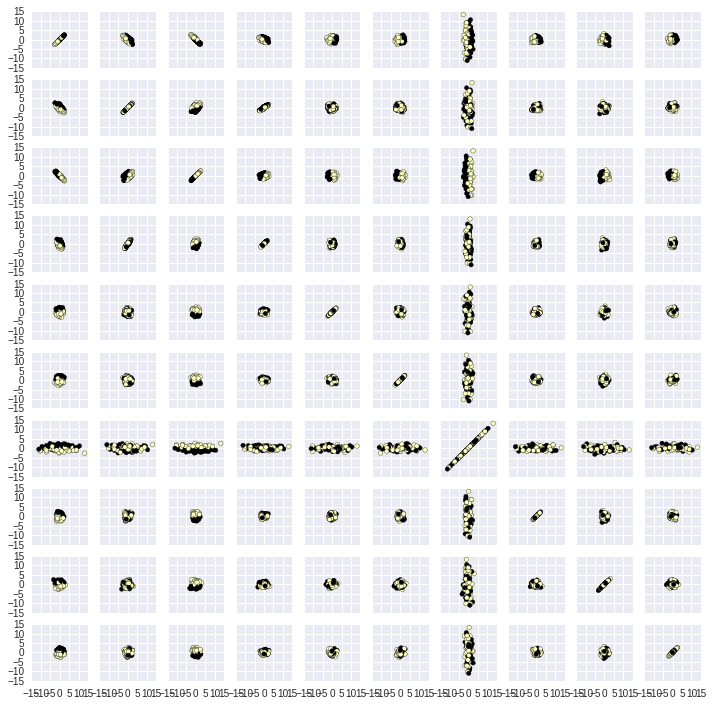

In [24]:
gridplot(scaled, labels)

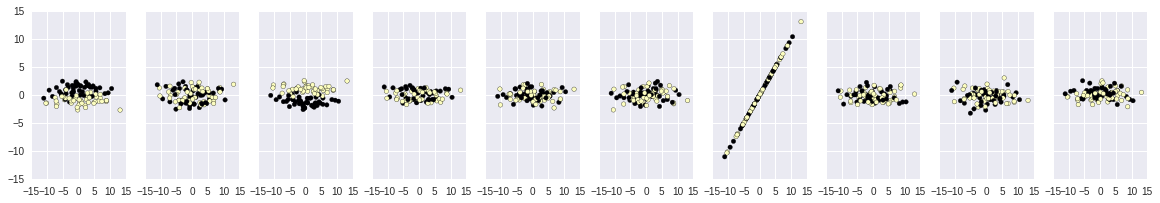

In [25]:
gridplot(scaled, labels, columns=6, figsize=(20,3))

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()
scaled[[6]] = scaler.fit_transform(scaled[[6]].values)

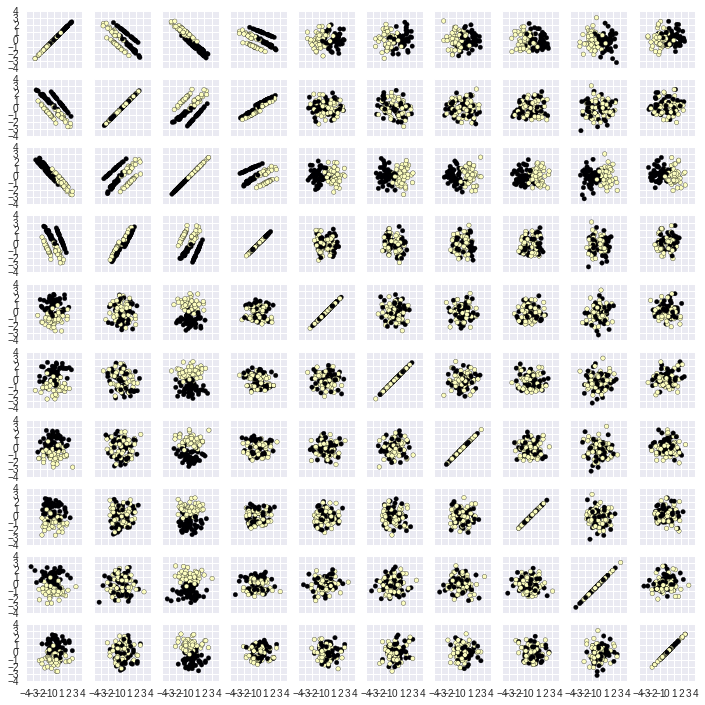

In [29]:
gridplot(scaled, labels)

### correlated features

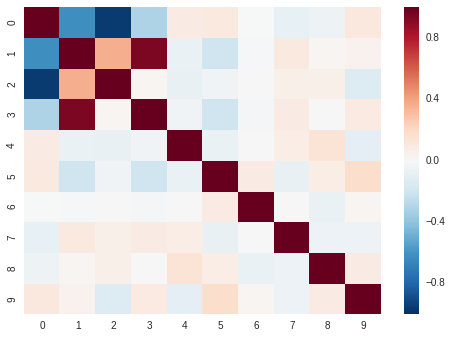

In [30]:
sns.heatmap(df.corr(), robust=True)

Not now. More about this topic in the next issue. Cough-cough-<a href="http://scikit-learn.org/stable/modules/preprocessing.html#scaling-data-with-outliers" style="color: black; text-decoration: none; cursor: default;">PCA</a>-cough.

### <a href="http://scikit-learn.org/stable/modules/preprocessing.html#scaling-data-with-outliers">outliers</a>

<img src="https://i0.wp.com/flowingdata.com/wp-content/uploads/2014/09/outlier.gif" align="left">

In [31]:
outlied = pd.DataFrame(add_outlier(data, value=100))
outlied.describe()

,0,1,2,3,4,5,6,7,8,9
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.038332,-0.048848,-0.027714,-0.031206,-0.019072,0.023822,0.046243,0.875936,-0.140833,0.154807
std,1.274375,1.230126,1.323957,0.894988,0.917525,1.029101,0.990537,10.146920,1.080806,0.943938
min,-2.683180,-2.523434,-2.585909,-1.692005,-2.301921,-2.650970,-2.211135,-1.710168,-3.241267,-2.081929
25%,-0.989945,-1.097573,-1.185113,-0.819243,-0.600541,-0.727945,-0.582521,-0.899020,-0.771818,-0.586988
50%,-0.098046,-0.035241,0.069846,0.098274,-0.028410,0.073685,0.030677,-0.231242,-0.037272,0.188380
75%,1.190847,1.035708,1.089659,0.707311,0.610424,0.708718,0.692567,0.672154,0.626192,0.624553
max,2.489048,2.388694,2.591239,1.724002,2.075401,2.445752,2.632382,100.889631,3.078881,2.573360


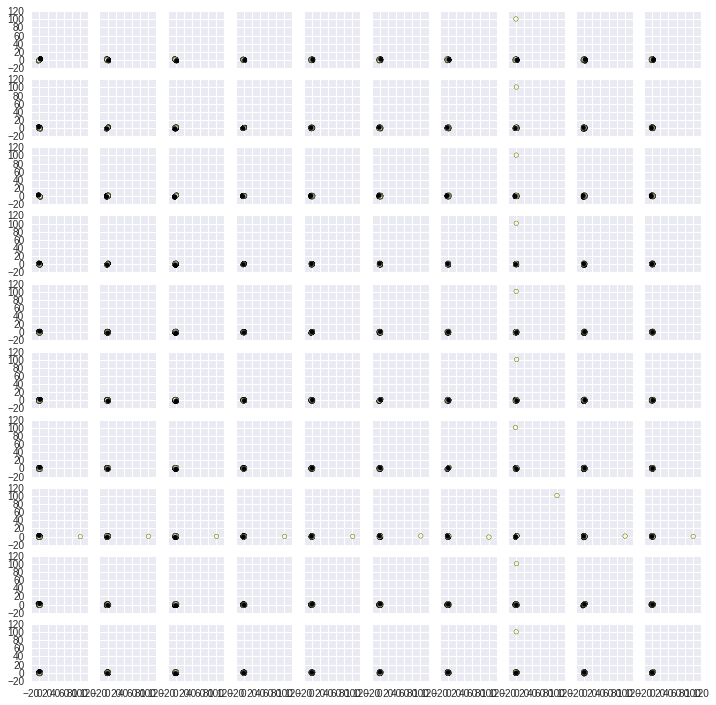

In [32]:
gridplot(outlied, labels)

### <a href="https://www.youtube.com/watch?v=MymAUbwSX80" style="color: black; text-decoration: none; cursor: default;">ACT NOW!</a> Write a function which removes the outlier from a dataframe!

In [37]:
def remove_outlier(df):
    """Removes the outlier from the given dataframe.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe with outliers.
        
    Returns:
    --------
    df' : pd.DataFrame
        The cleaned dataframe.
    """
    df_comma = df.copy()
    for col in df_comma.columns:
        mean, std = df[col].mean(), df[col].std()
        df_comma[col] = df[col][(df[col] < mean + 3*std) & (df[col] > mean - 3*std)]
    return df_comma

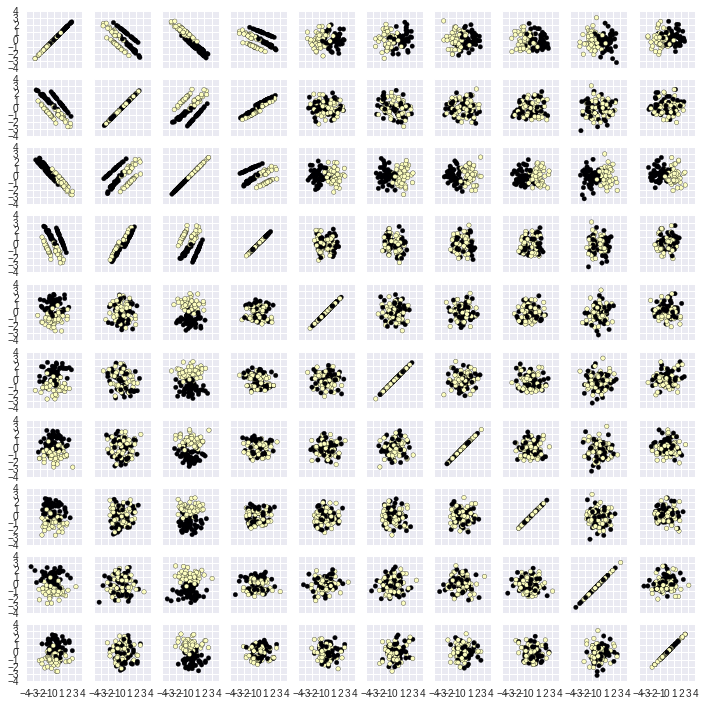

In [38]:
gridplot(remove_outlier(outlied), labels)

---
# HOMEWORK
- <a href="http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values">scikit-learn missing value inputation example</a>

---

### <a href="http://scikit-learn.org/stable/modules/preprocessing.html#feature-binarization">binarization</a>

In [5]:
from sklearn.preprocessing import Binarizer

In [10]:
binarizer = Binarizer()
binarizer.fit_transform(df)[:15]

array([[ 0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.],
       [ 0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.],
       [ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.],
       [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.],
       [ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

## Textual Transformations

### <a href="http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features">Categorical values</a>

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
categorical = binarize(data)

In [17]:
encoder = OneHotEncoder()
encoder.fit_transform(categorical).todense()

matrix([[ 1.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  1.,  1., ...,  1.,  0.,  1.],
        [ 0.,  1.,  0., ...,  0.,  0.,  1.],
        ..., 
        [ 0.,  1.,  1., ...,  0.,  1.,  0.],
        [ 1.,  0.,  0., ...,  1.,  0.,  1.],
        [ 0.,  1.,  1., ...,  1.,  0.,  1.]])

In [33]:
categorical = np.array([[np.random.choice([0,1,2])]
                        for _ in range(100)])

In [34]:
encoded = encoder.fit_transform(categorical)
encoded.shape

(100, 3)

In [39]:
categorical[:15]

array([[0],
       [1],
       [0],
       [1],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [0],
       [0],
       [2],
       [0],
       [1]])

In [40]:
encoded[:15].todense()

matrix([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  0.],
        [ 1.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 1.,  0.,  0.],
        [ 0.,  1.,  0.]])

### <a href="http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#bags-of-words">Bag of words</a>

In [42]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [44]:
twenty = fetch_20newsgroups(
    subset="train",
    categories=['sci.space', 'talk.politics.guns',
                'rec.motorcycles', 'misc.forsale']
)

X, y = twenty.data, twenty.target

In [49]:
vect = CountVectorizer(min_df=2, max_df=.9)
X_t = vect.fit_transform(X)
X_t

<2322x18391 sparse matrix of type '<type 'numpy.int64'>'
	with 317379 stored elements in Compressed Sparse Row format>

In [54]:
X_t[:10].todense()

matrix([[0, 2, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

### <a href="http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#from-occurrences-to-frequencies">Tf-Idf</a>

In [52]:
from sklearn.feature_extraction.text import TfidfTransformer

In [55]:
tfidf = TfidfTransformer()
X_t = tfidf.fit_transform(X_t)
X_t.shape

(2322, 18391)

In [56]:
X_t[:10].todense()

matrix([[ 0.        ,  0.09018504,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

## Pipelines and FeatureUnions

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import mean_squared_error

In [64]:
pipe = Pipeline(steps=[
    ('count', CountVectorizer(min_df=4, max_df=.8)),
    ('tfidf', TfidfTransformer()),
    ('knn', KNeighborsClassifier())    
])

In [78]:
# Use binary metric instead of rmse?
baseline = np.ones((len(y), 1)) * y.mean()
mean_squared_error(y, baseline)

1.2234700698334695

In [80]:
pipe.fit(X, y)
y_hat = pipe.predict(X)
mean_squared_error(y, y_hat)

0.12876830318690785